# SFRD from IR based data

Until now, we have been using UV observations to determine the luminosity functions and SFRDs from it. Now, let's turn our attention to the IR data. We currently have three references for such observations. We, for now, focus on these data. We try to propagate the errors correctly. Below, we show the results of this computation which were done using the code presented [here](https://github.com/Jayshil/csfrd/blob/main/c2_irlf_grp.py) and [here](https://github.com/Jayshil/csfrd/blob/main/p9_IR_SFRDs.ipynb). Here we do not assume any correlation among the luminosity function parameters.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import utils as utl
import astropy.constants as con
import astropy.units as u
import os

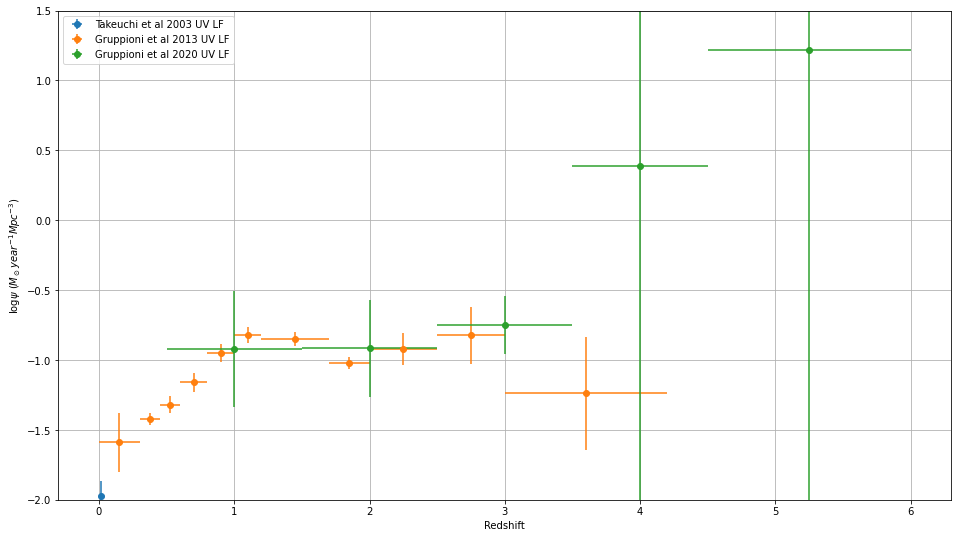

In [2]:
p2 = os.getcwd()
ppr_ir = np.array(['Takeuchi_et_al_2003', 'Gruppioni_et_al_2013', 'Gruppioni_et_al_2020'])

# Loading papers
ppr_ir1 = np.loadtxt(p2 + '/sfrd_ir_new.dat', usecols=0, unpack=True, dtype=str)
zd_ir, zu_ir, sfrd_ir, sfrd_ir_err = np.loadtxt(p2 + '/sfrd_ir_new.dat', usecols=(1,2,3,4), unpack=True)
zcen_ir = (zd_ir + zu_ir)/2
zup, zdo = np.abs(zu_ir - zcen_ir), np.abs(zcen_ir - zd_ir)
log_sfrd_ir, log_sfrd_ir_err = utl.log_err(sfrd_ir, sfrd_ir_err)

plt.figure(figsize=(16, 9))
# Plotting them
for i in range(len(ppr_ir)):
    zc_ir, zp, zn, lg_sf, lg_sfe = np.array([]), np.array([]), np.array([]), np.array([]), np.array([])
    for j in range(len(ppr_ir1)):
        if ppr_ir1[j] == ppr_ir[i]:
            zc_ir = np.hstack((zc_ir, zcen_ir[j]))
            lg_sf = np.hstack((lg_sf, log_sfrd_ir[j]))
            lg_sfe = np.hstack((lg_sfe, log_sfrd_ir_err[j]))
            zp = np.hstack((zp, zup[j]))
            zn = np.hstack((zn, zdo[j]))
    plt.errorbar(zc_ir, lg_sf, xerr=[zn, zp], yerr=lg_sfe, label=ppr_ir[i].replace('_',' ') + ' UV LF', fmt='o')

#plt.plot(znew, psi2, label='Best fitted function')
plt.xlabel('Redshift')
plt.ylabel(r'$\log{\psi}$ ($M_\odot year^{-1} Mpc^{-3}$)')
plt.ylim([-2.0, 1.5])
plt.grid()
plt.legend(loc='best')